###Imports

In [ ]:
import torch
import torchvision
from torch import nn
from torchvision import transforms
# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !mv pytorch-deep-learning/helper_functions.py . # get the helper_functions.py script
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves

[INFO] Couldn't find torchinfo... installing it.
[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.
Cloning into 'pytorch-deep-learning'...
remote: Enumerating objects: 4036, done.
remote: Counting objects: 100% (1224/1224), done.
remote: Compressing objects: 100% (226/226), done.
remote: Total 4036 (delta 1067), reused 1080 (delta 995), pack-reused 2812
Receiving objects: 100% (4036/4036), 651.50 MiB | 32.46 MiB/s, done.
Resolving deltas: 100% (2360/2360), done.
Updating files: 100% (248/248), done.


In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [ ]:
#Download pizza, steak, sushi images from GitHub
image_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                           destination="pizza_steak_sushi")
image_path

[INFO] Did not find data/pizza_steak_sushi directory, creating one...
[INFO] Downloading pizza_steak_sushi.zip from https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip...
[INFO] Unzipping pizza_steak_sushi.zip data...


PosixPath('data/pizza_steak_sushi')

In [ ]:
# Setup directory paths to train and test images
train_dir = image_path / "train"
test_dir = image_path / "test"

###Preprocess data

In [ ]:
IMG_SIZE = 224

manual_transforms = transforms.Compose([transforms.Resize((IMG_SIZE,IMG_SIZE)),
                                        transforms.ToTensor(),])
manual_transforms

Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=warn)
    ToTensor()
)

In [ ]:
#Set the batch size
BATCH_SIZE = 32

train_dataloader,test_dataloader,class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=manual_transforms,
    batch_size=BATCH_SIZE
)

train_dataloader,test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7e974805ffd0>,
 <torch.utils.data.dataloader.DataLoader at 0x7e974805e410>)

In [ ]:
# Get a batch of images
image_batch, label_batch = next(iter(train_dataloader))

# Get a single image from the batch
image, label = image_batch[0], label_batch[0]

# View the batch shapes
image.shape, label

(torch.Size([3, 224, 224]), tensor(1))

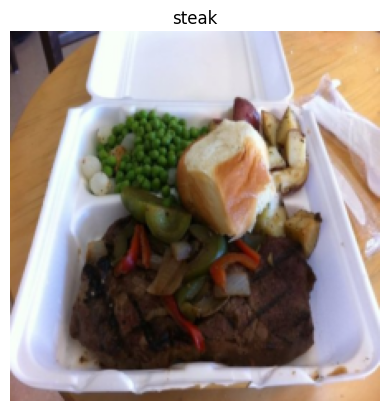

In [ ]:
# Plot image with matplotlib
import matplotlib.pyplot as plt
plt.imshow(image.permute(1, 2, 0)) # rearrange image dimensions to suit matplotlib [color_channels, height, width] -> [height, width, color_channels]
plt.title(class_names[label])
plt.axis(False);

###Replicating ViT(Base) - Testing Code

In [ ]:
#Patch Embedding
class PatchEmbedding(nn.Module):
  def __init__(self,
               in_channels:int=3,
               patch_size:int=16,
               embedding_dim:int=768):
    super().__init__()

    self.patch_size = patch_size

    #Create a layer to turn an image into patches
    self.patcher = nn.Conv2d(in_channels=in_channels,
                             out_channels=embedding_dim,
                             kernel_size=patch_size,
                             stride=patch_size,
                             padding=0)
    self.flatten = nn.Flatten(start_dim=2,end_dim=3)# only flatten the feature map dimensions into a single vector
  def forward(self,x):
    image_resolution = x.shape[-1]
    assert image_resolution%self.patch_size == 0,f"Input image size must be divisble by patch size, image shape: {image_resolution}"

    x_patched = self.patcher(x)
    x_flattened = self.flatten(x_patched)

    # Make sure the output shape has the right order
    return x_flattened.permute(0, 2, 1)

In [ ]:
rand_image_tensor = torch.randn(32, 3, 224, 224) # (batch_size, color_channels, height, width)
rand_image_tensor.shape

torch.Size([32, 3, 224, 224])

In [ ]:
patch_embedding = PatchEmbedding(patch_size=16)
patch_embedding_output = patch_embedding(rand_image_tensor)
print(f"Input shape: {rand_image_tensor.shape}")
print(f"Output shape: {patch_embedding_output.shape} -> (batch_size, num_patches, embedding_dim)")

Input shape: torch.Size([32, 3, 224, 224])
Output shape: torch.Size([32, 196, 768]) -> (batch_size, num_patches, embedding_dim)


In [ ]:
#Hyperparameters from ViT paper
transformer_encoder_layer = nn.TransformerEncoderLayer(d_model=768,
                                                       nhead=12,
                                                       dim_feedforward=3072,
                                                       dropout=0.1,
                                                       activation="gelu",
                                                       batch_first=True,
                                                       norm_first=True)
transformer_encoder_layer

TransformerEncoderLayer(
  (self_attn): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
  )
  (linear1): Linear(in_features=768, out_features=3072, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (linear2): Linear(in_features=3072, out_features=768, bias=True)
  (norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (dropout1): Dropout(p=0.1, inplace=False)
  (dropout2): Dropout(p=0.1, inplace=False)
)

In [ ]:
summary(model=transformer_encoder_layer,
        input_size=patch_embedding_output.shape)

Layer (type:depth-idx)                   Output Shape              Param #
TransformerEncoderLayer                  [32, 196, 768]            7,087,872
Total params: 7,087,872
Trainable params: 7,087,872
Non-trainable params: 0
Total mult-adds (M): 0
Input size (MB): 19.27
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 19.27

In [ ]:
transformer_encoder = nn.TransformerEncoder(
    encoder_layer=transformer_encoder_layer,
    num_layers=12
)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [ ]:
summary(model=transformer_encoder,
        input_size=patch_embedding_output.shape)

Layer (type:depth-idx)                   Output Shape              Param #
TransformerEncoder                       [32, 196, 768]            --
├─ModuleList: 1-1                        --                        --
│    └─TransformerEncoderLayer: 2-1      [32, 196, 768]            7,087,872
│    └─TransformerEncoderLayer: 2-2      [32, 196, 768]            7,087,872
│    └─TransformerEncoderLayer: 2-3      [32, 196, 768]            7,087,872
│    └─TransformerEncoderLayer: 2-4      [32, 196, 768]            7,087,872
│    └─TransformerEncoderLayer: 2-5      [32, 196, 768]            7,087,872
│    └─TransformerEncoderLayer: 2-6      [32, 196, 768]            7,087,872
│    └─TransformerEncoderLayer: 2-7      [32, 196, 768]            7,087,872
│    └─TransformerEncoderLayer: 2-8      [32, 196, 768]            7,087,872
│    └─TransformerEncoderLayer: 2-9      [32, 196, 768]            7,087,872
│    └─TransformerEncoderLayer: 2-10     [32, 196, 768]            7,087,872
│    └─Transfor

###ViT(Base)

In [ ]:
class ViT(nn.Module):
  def __init__(self,
               img_size=224,
               num_channels=3,
               patch_size=16,
               embedding_dim=768,
               dropout=0.1,
               mlp_size=3072,
               num_transformer_layers=12,
               num_heads=12,
               num_classes=1000):
    super().__init__()
    # Assert image size is divisible by patch size
    assert img_size % patch_size == 0, "Image size must be divisble by patch size."

    #Create patch embedding
    self.patch_embedding = PatchEmbedding(in_channels=num_channels,
                                          patch_size=patch_size,
                                          embedding_dim=embedding_dim)
    #Create class token
    self.class_token = nn.Parameter(torch.randn(1,1,embedding_dim),requires_grad=True)

    #Create Positional embedding
    num_patches = (img_size * img_size) // patch_size**2
    self.positional_embedding = nn.Parameter(torch.randn(1,num_patches+1,embedding_dim))

    #Create patch + positional embedding dropout
    self.embedding_dropout = nn.Dropout(p=dropout)

    #Create stack Transformer Encoder Layers
    self.transformer_encoder = nn.TransformerEncoder(encoder_layer=nn.TransformerEncoderLayer(d_model=embedding_dim,
                                                                                              nhead=num_heads,
                                                                                              dim_feedforward=mlp_size,
                                                                                              activation="gelu",
                                                                                              batch_first=True,
                                                                                              norm_first=True),
                                                     num_layers=num_transformer_layers) # Stack it N times
    #Create MLP head
    self.mlp_head = nn.Sequential(nn.LayerNorm(normalized_shape=embedding_dim),
                                  nn.Linear(in_features=embedding_dim,
                                            out_features=num_classes))
  def forward(self,x):
    batch_size = x.shape[0]

    x = self.patch_embedding(x)

    class_token = self.class_token.expand(batch_size,-1,-1) #-1 means infer from above

    #prepend the class token to the patch embedding
    x = torch.cat((class_token,x),dim=1)

    x = self.positional_embedding + x

    x = self.embedding_dropout(x)

    x = self.transformer_encoder(x)

    #Pass 0th index of x through MLP head
    x = self.mlp_head(x[:,0])

    return x

In [ ]:
demo_img = torch.randn(1, 3, 224, 224).to(device)
summary(model=ViT(num_classes=3),
        input_size=demo_img.shape)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Layer (type:depth-idx)                        Output Shape              Param #
ViT                                           [1, 3]                    152,064
├─PatchEmbedding: 1-1                         [1, 196, 768]             --
│    └─Conv2d: 2-1                            [1, 768, 14, 14]          590,592
│    └─Flatten: 2-2                           [1, 768, 196]             --
├─Dropout: 1-2                                [1, 197, 768]             --
├─TransformerEncoder: 1-3                     [1, 197, 768]             --
│    └─ModuleList: 2-3                        --                        --
│    │    └─TransformerEncoderLayer: 3-1      [1, 197, 768]             7,087,872
│    │    └─TransformerEncoderLayer: 3-2      [1, 197, 768]             7,087,872
│    │    └─TransformerEncoderLayer: 3-3      [1, 197, 768]             7,087,872
│    │    └─TransformerEncoderLayer: 3-4      [1, 197, 768]             7,087,872
│    │    └─TransformerEncoderLayer: 3-5      [1, 197, 76

###Converting into Python Script

In [ ]:
%%writefile vit.py
import torch
import torchvision
from torch import nn
from torchvision import transforms
#Patch Embedding
class PatchEmbedding(nn.Module):
  def __init__(self,
               in_channels:int=3,
               patch_size:int=16,
               embedding_dim:int=768):
    super().__init__()

    self.patch_size = patch_size

    #Create a layer to turn an image into patches
    self.patcher = nn.Conv2d(in_channels=in_channels,
                             out_channels=embedding_dim,
                             kernel_size=patch_size,
                             stride=patch_size,
                             padding=0)
    self.flatten = nn.Flatten(start_dim=2,end_dim=3)# only flatten the feature map dimensions into a single vector
  def forward(self,x):
    image_resolution = x.shape[-1]
    assert image_resolution%self.patch_size == 0,f"Input image size must be divisble by patch size, image shape: {image_resolution}"

    x_patched = self.patcher(x)
    x_flattened = self.flatten(x_patched)

    # Make sure the output shape has the right order
    return x_flattened.permute(0, 2, 1)
class ViT(nn.Module):
  def __init__(self,
               img_size=224,
               num_channels=3,
               patch_size=16,
               embedding_dim=768,
               dropout=0.1,
               mlp_size=3072,
               num_transformer_layers=12,
               num_heads=12,
               num_classes=1000):
    super().__init__()
    # Assert image size is divisible by patch size
    assert img_size % patch_size == 0, "Image size must be divisble by patch size."

    #Create patch embedding
    self.patch_embedding = PatchEmbedding(in_channels=num_channels,
                                          patch_size=patch_size,
                                          embedding_dim=embedding_dim)
    #Create class token
    self.class_token = nn.Parameter(torch.randn(1,1,embedding_dim),requires_grad=True)

    #Create Positional embedding
    num_patches = (img_size * img_size) // patch_size**2
    self.positional_embedding = nn.Parameter(torch.randn(1,num_patches+1,embedding_dim))

    #Create patch + positional embedding dropout
    self.embedding_dropout = nn.Dropout(p=dropout)

    #Create stack Transformer Encoder Layers
    self.transformer_encoder = nn.TransformerEncoder(encoder_layer=nn.TransformerEncoderLayer(d_model=embedding_dim,
                                                                                              nhead=num_heads,
                                                                                              dim_feedforward=mlp_size,
                                                                                              activation="gelu",
                                                                                              batch_first=True,
                                                                                              norm_first=True),
                                                     num_layers=num_transformer_layers) # Stack it N times
    #Create MLP head
    self.mlp_head = nn.Sequential(nn.LayerNorm(normalized_shape=embedding_dim),
                                  nn.Linear(in_features=embedding_dim,
                                            out_features=num_classes))
  def forward(self,x):
    batch_size = x.shape[0]

    x = self.patch_embedding(x)

    class_token = self.class_token.expand(batch_size,-1,-1) #-1 means infer from above

    #prepend the class token to the patch embedding
    x = torch.cat((class_token,x),dim=1)

    x = self.positional_embedding + x

    x = self.embedding_dropout(x)

    x = self.transformer_encoder(x)

    #Pass 0th index of x through MLP head
    x = self.mlp_head(x[:,0])

    return x

Overwriting vit.py


In [ ]:
!python vit.py

In [ ]:
from vit import ViT
demo_img = torch.randn(1, 3, 224, 224).to(device)
summary(model=ViT(num_classes=3),
        input_size=demo_img.shape)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Layer (type:depth-idx)                        Output Shape              Param #
ViT                                           [1, 3]                    152,064
├─PatchEmbedding: 1-1                         [1, 196, 768]             --
│    └─Conv2d: 2-1                            [1, 768, 14, 14]          590,592
│    └─Flatten: 2-2                           [1, 768, 196]             --
├─Dropout: 1-2                                [1, 197, 768]             --
├─TransformerEncoder: 1-3                     [1, 197, 768]             --
│    └─ModuleList: 2-3                        --                        --
│    │    └─TransformerEncoderLayer: 3-1      [1, 197, 768]             7,087,872
│    │    └─TransformerEncoderLayer: 3-2      [1, 197, 768]             7,087,872
│    │    └─TransformerEncoderLayer: 3-3      [1, 197, 768]             7,087,872
│    │    └─TransformerEncoderLayer: 3-4      [1, 197, 768]             7,087,872
│    │    └─TransformerEncoderLayer: 3-5      [1, 197, 76